In [1]:
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from bct.algorithms.clustering import agreement
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.anova import AnovaRM

from tqdm.notebook import tqdm

from os.path import join
from dn_utils.path import path
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.misc import tidy_data
from dn_utils.style import BLUE, ORANGE
from dn_utils.plotting import plot_matrix

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_corrmats = join(path["bsc"], "corrmats")

In [3]:
gamma_range = np.arange(0.5, 3.5, 0.25)
atlas = "combined_roi"

### Define functions

In [4]:
def anova_rm(data, labels, depvar="variable", show_plot=True):
    data = tidy_data(data, depvar=depvar,
                     columns=["sub", "con", "perr_sign"], labels=labels)
    anova = AnovaRM(data=data, depvar=depvar, subject="sub", 
                    within=["con", "perr_sign"])
    results = anova.fit()
    
    # Visualize
    if show_plot:
        fig, ax = plt.subplots(figsize=(5, 4))
        palette = {"perr_pos": ORANGE, "perr_neg": BLUE}
        sns.boxplot(x="con", y=depvar, hue="perr_sign", data=data, ax=ax, 
                    palette=palette)
        plt.legend(loc="lower right")
        plt.show()
    
    return results.anova_table

def fdrcorrection_matrix(arr):
    """Apply fdr correction for matrix elements including diagonal entries."""
    n = arr.shape[0]

    # Vectorize
    v_triu = arr[np.triu_indices(n)]

    # Restore 2D matrix
    new = np.zeros((n, n))
    new[np.triu_indices(n)] = fdrcorrection(v_triu)[1]
    new = new + np.tril(new.T, k=-1)
    
    return new

### Load data

In [5]:
# Load behavioral data
beh, meta = load_behavioral_data(path["behavioral"], verbose=False)

# Load correlation matrices and metadata
corrmats_aggregated = np.load(
    join(path_corrmats, atlas, "corrmats_aggregated.npy"))
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    corrmats_meta = json.loads(f.read()) 

# Load subject exclusion
df_exclusion = pd.read_csv(
    join(path["nistats"], "exclusion/exclusion.csv"), index_col=0)
ok_index = df_exclusion["ok_all"]

# Load ROI information
df_roi = pd.read_csv(
    join(path_corrmats, atlas, "roi_table_filtered.csv"), index_col=0)
df_roi = df_roi.reset_index()

network_names = df_roi["netName"].unique()
n_nets = len(network_names)

# Labels for RM Anova
labels = [
    pd.Series(corrmats_meta["dim1"])[ok_index].to_list(),
    corrmats_meta["dim2"], 
    corrmats_meta["dim3"]
]

In [6]:
gamma = 1.5

In [7]:
print(f"Loading data for γ={gamma}")

gamma_str = str(float(gamma)).replace('.', '_')
path_graph = join(path_corrmats, atlas, "unthr", f"gamma_{gamma_str}")

# Load data
m = np.load(join(path_graph, "m_aggregated.npy"))
q = np.load(join(path_graph, "q_aggregated.npy"))
z = np.load(join(path_graph, "z_aggregated.npy"))
p = np.load(join(path_graph, "p_aggregated.npy"))    
d = np.load(join(path_graph, "d_networks.npy"))    
d_null = np.load(join(path_graph, "d_networks_null.npy"))
n_nulls = len(d_null)

# Calculate mean over conditions & filter subjects
d_perr = np.mean(d, axis=1)[ok_index]  # mean over conditions
d_con = np.mean(d, axis=2)[ok_index]   # mean over perr signs
d_null_perr = np.mean(d_null, axis=2)[:, ok_index]
d_null_con = np.mean(d_null, axis=3)[:, ok_index]

# Calculate stats on real data
ttest_perr_diff, pvals_perr_diff = ttest_rel(d_perr[:, 0], d_perr[:, 1])
ttest_con_diff, pvals_con_diff = ttest_rel(d_con[:, 0], d_con[:, 1])

# Monte Carlo p-values
ttest_perr_diff_mc = np.zeros((n_nulls, n_nets, n_nets))
ttest_con_diff_mc = np.zeros((n_nulls, n_nets, n_nets))

# Null distribution for ttests
for rep in tqdm(range(n_nulls)):
    ttest_perr_diff_mc[rep], _ = ttest_rel(
        a=d_null_perr[rep, :, 0],
        b=d_null_perr[rep, :, 1],
    )
    ttest_con_diff_mc[rep], _ = ttest_rel(
        a=d_null_con[rep, :, 0],
        b=d_null_con[rep, :, 1],
    )

    
# Convert to p values & apply FDR
pvals_perr_diff_mc = np.min(
    (np.mean(ttest_perr_diff < ttest_perr_diff_mc, axis=0), 
     np.mean(ttest_perr_diff > ttest_perr_diff_mc, axis=0)), axis=0) * 2
pvals_con_diff_mc = np.min(
    (np.mean(ttest_con_diff < ttest_con_diff_mc, axis=0), 
     np.mean(ttest_con_diff > ttest_con_diff_mc, axis=0)), axis=0) * 2

pvals_perr_diff_mc_fdr = fdrcorrection_matrix(pvals_perr_diff_mc)
pvals_con_diff_mc_fdr = fdrcorrection_matrix(pvals_con_diff_mc)

Loading data for γ=1.5


  0%|          | 0/10000 [00:00<?, ?it/s]

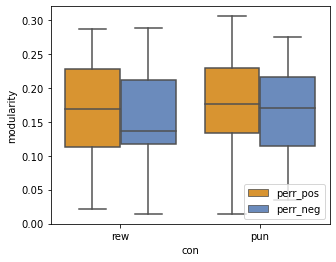

,F Value,Num DF,Den DF,Pr > F
con,0.081685,1.0,28.0,0.777130
perr_sign,0.689821,1.0,28.0,0.413252
con:perr_sign,0.048847,1.0,28.0,0.826686


In [8]:
anova_rm(q[ok_index], labels, "modularity")

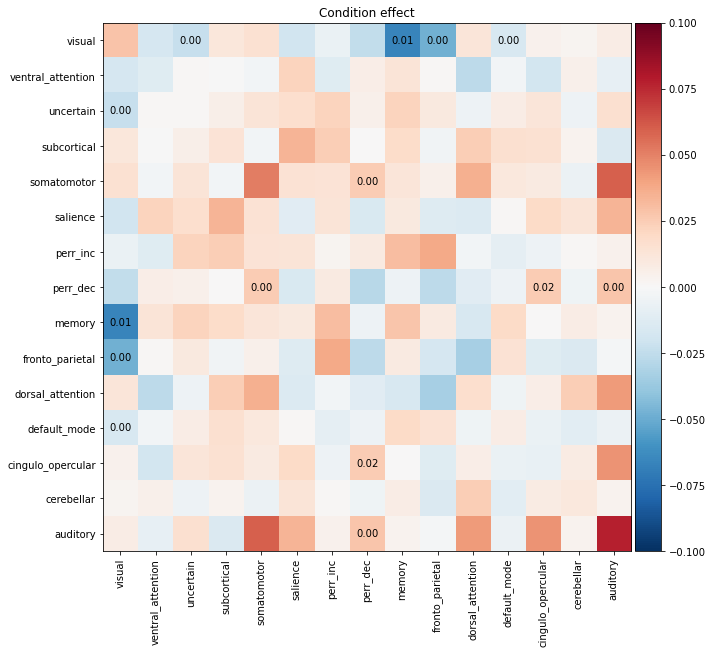

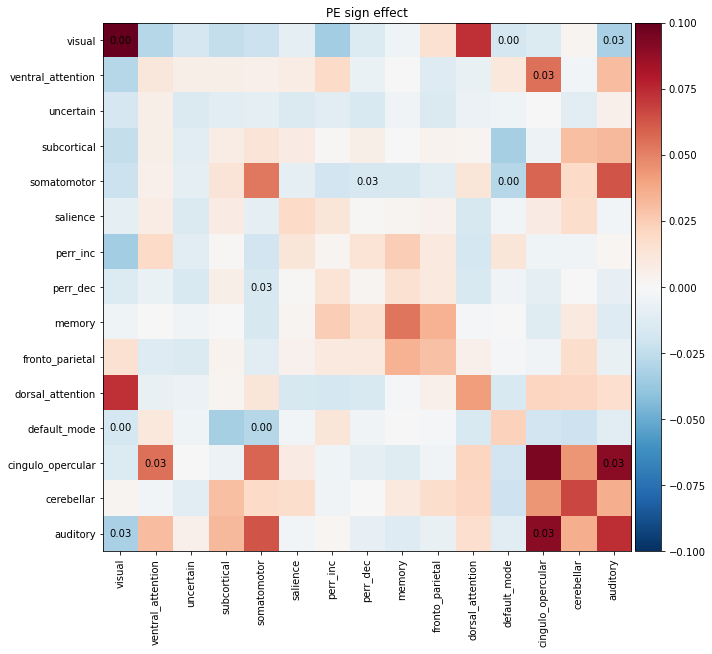

In [9]:
pvals = pvals_con_diff_mc
pvals_fdr = pvals_con_diff_mc_fdr

plot_matrix(
    np.mean(d_con[:, 0] - d_con[:, 1], axis=0),
#     ttest_con_diff,
    labels=network_names,
    annotate=pvals_fdr,
    annotate_mask=pvals_fdr < 0.05,
    title="Condition effect",
#     clim=(-3, 3)
    clim=(-.1, .1)
)

pvals = pvals_perr_diff_mc
pvals_fdr = pvals_perr_diff_mc_fdr

plot_matrix(
    np.mean(d_perr[:, 0] - d_perr[:, 1], axis=0),
#     ttest_perr_diff,
    labels=network_names,
    annotate=pvals_fdr,
    annotate_mask=pvals_fdr < 0.05,
    title="PE sign effect",
#     clim=(-3, 3)
    clim=(-.1, .1)
)